# **Methylation Biomarkers for Predicting Cancer**

## **Logistic Regression for Cancer Classification - Clinical Data + RF Features**

**Author:** Meg Hutch

**Date:** March 17, 2020

**Objective:** Use logistic regression  to classify cancer type. Since this is a multi-classification problem, we will use one-vs-one.

**Update: Got this to work!! It's the log_loss function that was giving us trouble for some reason, removing it seemed to do the trick I just need to ensure it wasn't important**

Note: For the AUC plots, the AUC score is different than what is generated by the evaluate_model, but I think this has to do with the settings for the multi-classification, ie: ovo, average, etc, which i will need to figure out how to add in the plotting function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
# set working directory for git hub
import os
os.chdir('/home/mrh1996/Multi_Cancer_DL/')
#os.chdir('/projects/p31049/Multi_Cancer_DL/')
#os.chdir('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/')
os. getcwd()

'/home/mrh1996/Multi_Cancer_DL'

**Import Data**

In [3]:
# Training set
mcTrain_x = pd.read_csv('02_Processed_Data/Final_Datasets/mcTrain_x_Full_70_30.csv')
mcTrain_y = pd.read_csv('02_Processed_Data/Final_Datasets/mcTrain_y_Full_70_30.csv')
# Testing set
mcTest_x = pd.read_csv('02_Processed_Data/Final_Datasets/mcTest_x_Full_70_30.csv')
mcTest_y = pd.read_csv('02_Processed_Data/Final_Datasets/mcTest_y_Full_70_30.csv')

# Random Forest Features
rf_feats = pd.read_csv('02_Processed_Data/Final_Datasets/rf_100feats_FULL_70_30.csv')

# **Pre-Process Data**

**Rename the first column name of the rf_feats dataframes**

In [4]:
rf_feats.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)

**Select the top 8 most important genes**

In [5]:
rf_feats.sort_values(by='0', ascending=False)
rf_feats = rf_feats.head(8)

**Remove the Importance Column**

In [6]:
rf_feats = rf_feats.drop(columns=["0"])

**Convert id to index**

In [7]:
mcTrain_x = mcTrain_x.set_index('id')
mcTrain_y = mcTrain_y.set_index('id')

mcTest_x = mcTest_x.set_index('id')
mcTest_y = mcTest_y.set_index('id')

**Create seperate DF with only Clinical Variables**

In [8]:
mcTrain_clinical_x = mcTrain_x[['dilute_library_concentration', 'age', 'gender', 'frag_mean']]
mcTest_clinical_x = mcTest_x[['dilute_library_concentration', 'age', 'gender', 'frag_mean']]

**Keep only the Genes that were in the rf_feats**

In [9]:
# Create a list of the Genes to keep
rf_genes = rf_feats.Gene
# convert to df
rf_genes = pd.DataFrame(rf_genes)
# set Gene as an index
rf_genes = rf_genes.set_index('Gene')
# Create a list of the gene names
rf_genes = list(rf_genes.index)
rf_genes

['LMO7DN', 'EVC', 'DPYSL2', 'EPB41', 'G6PC', 'HSPB8', 'PRELID2', 'MED18']

In [10]:
mcTrain_x = mcTrain_x[rf_genes]
mcTest_x = mcTest_x[rf_genes]
mcTrain_x

,LMO7DN,EVC,DPYSL2,EPB41,G6PC,HSPB8,PRELID2,MED18
id,,,,,,,,
1,69.438420,274.690219,1748.214328,2400.731241,182.786428,164.405670,1325.456891,136.834533
2,73.950495,262.808681,1713.376078,2436.953227,220.713784,126.284691,1399.370900,137.661690
3,80.060550,179.828312,1911.599596,2321.755952,230.328044,161.352801,1526.077255,115.779872
4,92.428914,231.072286,1754.182802,2466.082100,163.225530,153.392667,1492.628640,129.793795
5,80.767629,212.265338,1816.937895,2435.711381,196.912814,156.195249,1632.040100,101.460162
...,...,...,...,...,...,...,...,...
238,69.810532,152.520836,1575.289828,2644.453300,214.743267,128.238912,1358.270131,140.379874
239,90.682730,193.456490,1774.358746,2449.945083,204.036142,139.046852,1413.139206,116.376170
240,69.946359,137.394633,1858.574676,2430.635967,184.025539,152.383139,1349.798185,94.094506


In [11]:
# merge PCs with clinical/phenotypic data
mcTrain_x = pd.merge(mcTrain_clinical_x, mcTrain_x, how="left", on="id") 
mcTest_x = pd.merge(mcTest_clinical_x, mcTest_x, how="left", on="id") 

**Drop the library concentraion (should have already controlled for this perhaps with deseq2 normalization?); Just simply keep demographic data for these experiments!**

In [12]:
mcTrain_x = mcTrain_x.drop(columns=["dilute_library_concentration"])
mcTest_x = mcTest_x.drop(columns=["dilute_library_concentration"])

**Normalize Data**

From my reading, it seems that normalization, as opposed to standardization, is the more optimal approach when data is not normally distributed. 

Normalization will rescale our values into range of [0,1]. We need to normalize both the training and test sets

In [13]:
from sklearn.preprocessing import MinMaxScaler

# The normalization function to be performed will convert dataframe into array, for this reason we'll have to convert it back
# Thus, need to store columns and index
# select all columns
cols = list(mcTrain_x.columns.values)
index_train = list(mcTrain_x.index)
index_test = list(mcTest_x.index)

# Normalize data
scaler = MinMaxScaler()
mcTrain_x = scaler.fit_transform(mcTrain_x.astype(np.float))
mcTest_x = scaler.fit_transform(mcTest_x.astype(np.float))

# Convert back to dataframe
mcTrain_x = pd.DataFrame(mcTrain_x, columns = cols, index = index_train)
mcTest_x = pd.DataFrame(mcTest_x, columns = cols, index = index_test)

**Convert y into 1D vector**

In [14]:
mcTrain_y = mcTrain_y.diagnosis.values
mcTest_y = mcTest_y.diagnosis.values

**Convert to arrays**

In [15]:
# Convert all to arrays
mcTrain_x = mcTrain_x.values
mcTest_x = mcTest_x.values

# **Logistic Regression**

Code adapted from Garret's modeling lecture:https://github.com/geickelb/HSIP442_guest_lecture/blob/master/notebooks/modeling.ipynb

In [16]:
def evaluate_model(model, x, y, cv=True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import StratifiedKFold

    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5)))

    print("###metrics on provided dataset:###")
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    #errors = abs(y_hat - y)
    #mape = 100 * np.mean(errors / y) # mean absolute percentage error
    #accuracy = 100 - mape 
    auc=roc_auc_score(y, y_proba, multi_class = 'ovo', average = 'weighted')
    #loss= log_loss(y, y_hat)

    print ('the AUC is: {:0.3f}'.format(auc))
    #print ('the logloss is: {:0.3f}'.format(loss))
    print("confusion matrix:\n ", confusion_matrix(y, y_hat))
    print("classification report:\n ", classification_report(y,y_hat, digits=3))

    ez_roc(model, x, y, pos_label=1) #plotting roc curve
    plt.show()
    #ez_prc(model, x, y, pos_label=1) #plotting roc curve
    #plt.show()

In [17]:
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Recievor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

In [18]:
def ez_prc(model, x, y, pos_label=1):    
    """prints a basic Precision-Recall curve. 
    recall: the porportion of positives in the dataset that were correctly classified. (true_pos/ (true_pos + false_neg))
    precision: the porportion of predicted y=1 values that are correct (true_pos/ (true_pos + false_pos))

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import average_precision_score, precision_recall_curve

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]

    precision, recall, thresholds = precision_recall_curve(y, y_proba, pos_label=1, sample_weight=None)
    avg_p=average_precision_score(y, y_proba, pos_label=1, sample_weight=None)
    
    plt.title('Precision-Recall curve')
    ax1= plt.plot(precision, recall, 'b', label = '%s AP = %0.3f' % (model_name, avg_p), linewidth=2)
    plt.legend(loc = 'lower left')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')

**Guide to parameters:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Notes: "For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes."

**Evaluate the Training Set**

In [19]:
#define model
lr= LogisticRegression(penalty='l2', solver='newton-cg', random_state = 12345)

#fit model
lr.fit(mcTrain_x, mcTrain_y)

y_hat = lr.predict(mcTrain_x) # predicted classes using default 0.5 threshold
y_proba = lr.predict_proba(mcTrain_x)[:,] #predicted probabilities

roc_auc_score(mcTrain_y, y_proba, multi_class = 'ovo', average = 'weighted')

#evaluate model (on training data)

#evaluate_model(lr, mcTrain_x, mcTrain_y, cv=True) 

0.8144483773925301

**Evaluate the Training Set with the Code above**

The AUC is the same, good! And we also get the mean auroc across cross-fold validations

**Note:** I think the ROC plot may just be plotting one case...unclear, need to look in to maybe plotting averages...though it probably isn't super important for the training set

across 5 fold cv on trainingset, the model had 
 mean auroc: 0.757 
 std auroc: 0.010
###metrics on provided dataset:###
the AUC is: 0.814
confusion matrix:
  [[51  4  0  4  1  1  0]
 [17 12  1  9  5  0  1]
 [ 4  8  1  8  2  0  1]
 [ 8  7  0 29  2  0  3]
 [ 7  4  2  4  8  0  1]
 [ 8  1  0  6  1  2  1]
 [ 7  3  0  2  0  0  6]]
classification report:
                precision    recall  f1-score   support

           0      0.500     0.836     0.626        61
           1      0.308     0.267     0.286        45
           2      0.250     0.042     0.071        24
           3      0.468     0.592     0.523        49
           4      0.421     0.308     0.356        26
           5      0.667     0.105     0.182        19
           6      0.462     0.333     0.387        18

    accuracy                          0.450       242
   macro avg      0.439     0.355     0.347       242
weighted avg      0.435     0.450     0.405       242



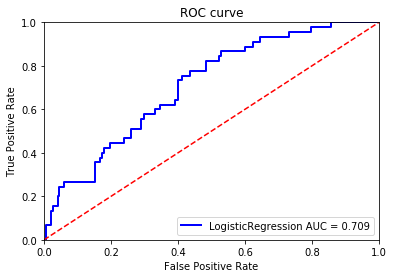

In [20]:
y_hat = lr.predict(mcTrain_x) # predicted classes using default 0.5 threshold
y_proba = lr.predict_proba(mcTrain_x)[:,] #predicted probabilities
evaluate_model(lr, mcTrain_x, mcTrain_y, cv=True) 

**Evaluate the Test Set**

CV = FALSE, because we don't want to do cross-fold validaiton on the test set


 LogisticRegression:
###metrics on provided dataset:###
the AUC is: 0.804
confusion matrix:
  [[25  0  0  0  0  0  0]
 [ 9  2  0  8  0  0  0]
 [ 6  0  0  3  1  0  0]
 [ 6  0  0 15  0  0  0]
 [ 5  2  0  4  0  0  0]
 [ 4  0  0  3  0  0  0]
 [ 3  0  0  1  0  0  3]]
classification report:
                precision    recall  f1-score   support

           0      0.431     1.000     0.602        25
           1      0.500     0.105     0.174        19
           2      0.000     0.000     0.000        10
           3      0.441     0.714     0.545        21
           4      0.000     0.000     0.000        11
           5      0.000     0.000     0.000         7
           6      1.000     0.429     0.600         7

    accuracy                          0.450       100
   macro avg      0.339     0.321     0.275       100
weighted avg      0.365     0.450     0.340       100



/home/mrh1996/.conda/envs/envs_dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


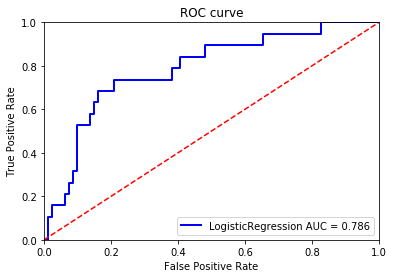

In [21]:
print('\n LogisticRegression:')
evaluate_model(lr,mcTest_x,mcTest_y, cv=False)